In [1]:
import scipy.io
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from fancy_plots import fancy_plots_3
from fancy_plots import plot_states_angles_estimation, plot_states_velocity_lineal_estimation, plot_states_velocity_angular_estimation, plot_control_states_estimation
from fancy_plots import fancy_plots_2
from fancy_plots import fancy_plots_1, plot_error_estimation, plot_states_position_estimation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.nn.modules.container import T
from tqdm import tqdm
from collections import defaultdict
import random

In [2]:

if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu"
device = torch.device(dev)
print(torch.cuda.is_available())

True


In [3]:
def get_odometry(data, angle, vx, vy, vz, wx, wy, wz, vel_control, steer_control, samples_i, samples_f):
    # Get size of the data
    i, j = data.shape
    # Init empty values
    x = np.zeros((1, j), dtype = np.double)
    y = np.zeros((1, j), dtype = np.double)
    z = np.zeros((1, j), dtype = np.double)
    quatenions = np.zeros((4, j), dtype = np.double)
    orientation_aux = np.zeros((3, j), dtype = np.double)
    
    for k in range(0, j):
        
        # Get Position
        x[:, k] = data[0, k]
        y[:, k] = data[1, k]
        z[:, k] = 0
        
        # Get quaternion
        quatenions[:, k] = [data[2, k], data[3, k], data[4, k], data[5, k]]
        
        # Get Euler Angles
        aux =  quatenions[:, k]
        r = R.from_quat(aux)
        orientation_aux[:, k] = r.as_euler('xyz', degrees = False)
        
    # get complete data of the system
    h = np.array([x[0,:], y[0,:], z[0,:],
                quatenions[0, :], quatenions[1, :], quatenions[2, :], quatenions[3, :],
                orientation_aux[0, :], orientation_aux[1, :], orientation_aux[2, :],
                angle[0, :]], dtype =np.double) 
    
    # Get Velocities of the system
    hp = np.array([vx[0, :], vy[0, :], vz[0, :], wx[0, :], wy[0, :], wz[0, :]], dtype = np.double)
    T = np.array([vel_control[0,:], steer_control[0, :]], dtype = np.double)
    return h[:, samples_i:samples_f+1], hp[:, samples_i:samples_f+1], T[:, samples_i:samples_f]


In [4]:
def get_simple_data(h, hp, T):
    ## Position
    x = h[0, :]
    y = h[1, :]
    ## Linear velocities
    vx = hp[0, :]
    vy = hp[1, :]
    vz = hp[2, :]
    
    ## Get angular velocities
    p = hp[3, :]
    q = hp[4, :]
    r = hp[5, :]
    
    ## Angular velocities vector
    omega = hp[3:6, :]
    
    ## Orientacion
    quaternion = h[3:7, :]
    
    ##euler
    euler = h[7:10, :]
    
    ## Steer angle = 
    alpha = h[10, :]
    
    ## General states data
    #X = np.array([euler[2,:], omega[2, :], alpha, vx, vy], dtype = np.double)
    #X = np.array([euler[0, :], euler[1, :], euler[2, :], omega[0, :], omega[1, :], omega[2, :], alpha, vx, vy, x, y], dtype = np.double)
    X = np.array([euler[2, :], omega[2, :], alpha, vx, x, y], dtype = np.double)
    ## Control Action
    U_ref = T[:, :]
    
    ## Get the dimension of the Data
    i, j = X.shape
    
    X1 = X[:, 0:j-1]
    X2 = X[:, 1:j]
    return X1, X2, U_ref

In [5]:
def liftFun(x):
    x_lift = []
    for k in x: x_lift.append(k)
    x_lift.append(np.tan(x[2, :]))

    x_lift.append(np.tan(x[2, :])*x[3, :])

    x_lift.append(np.cos(x[2, :])*x[3, :])
    x_lift.append(np.sin(x[2, :])*x[3, :])
    
    x_lift.append(np.cos(x[0, :])*x[3, :])

    x_lift.append(np.sin(x[0, :])*x[3, :])

    x_lift = np.array(x_lift, dtype = np.double)
    return x_lift


In [6]:
def liftFun_vector(x):
    x_lift = []
    for k in x: x_lift.append(k)
    x_lift.append(np.tan(x[2]))

    x_lift.append(np.tan(x[2])*x[3])

    x_lift.append(np.cos(x[2])*x[3])
    x_lift.append(np.sin(x[2])*x[3])
    
    x_lift.append(np.cos(x[0])*x[3])

    x_lift.append(np.sin(x[0])*x[3])

    x_lift = np.array(x_lift, dtype = np.double)
    return x_lift

In [7]:
def create_matrix(A, data):
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            A[i, j] = data[i, j]
    return A

In [8]:
def cost_function_koopman(X_1, X_k, U, alpha, beta, n, m, n_normal):
    # Create Matrices of the system
    A = ca.MX.sym('A', n, n)
    B = ca.MX.sym('B', n, m)
    C_ones = ca.MX.eye(n_normal)
    C_zeros = ca.MX.zeros(n_normal, n-n_normal)
    C_a = ca.horzcat(C_ones, C_zeros)
    
    ## Create data in Casadi variables
    i_states, j_states = X_1.shape
    i_control, j_control = U.shape
    
    X_1_ca = ca.MX.zeros(i_states, j_states)
    X_1_ca = create_matrix(X_1_ca, X_1)
    
    X_k_ca = ca.MX.zeros(i_states, j_states)
    X_k_ca = create_matrix(X_k_ca, X_k)
    
    U_ca = ca.MX.zeros(i_control, j_control)
    U_ca = create_matrix(U_ca, U)

    ## Initial cost
    obj = 0

    args = {}
    
    for k in range(0, U_ca.shape[1]):
        x_1 = C_a@X_1_ca[:, k]
        x_k = C_a@X_k_ca[:, k]
        
        Gamma_k = X_k_ca[:, k]
        Gamma_1 = X_1_ca[:, k]
        
        error_koop = Gamma_k - A@Gamma_1 - B@U_ca[:, k]
        error_prediction = x_k - C_a@(A@Gamma_1 + B@U_ca[:, k])
        obj = obj + beta*ca.norm_fro(error_koop) + ca.norm_fro(error_prediction) 
    
    obj = obj + alpha*ca.norm_fro(A) + alpha*ca.norm_fro(B)

    OPT_variables = ca.vertcat(A.reshape((-1, 1)), B.reshape((-1, 1)))
    # Initial Values Problem 
    A_0 = ca.DM.eye(n)*0.1
    B_0 = ca.DM.ones(n, m)*0.1

    # Definition optimal control problem
    nlp_prob = {'f': obj,'x': OPT_variables}
    opts = {'ipopt': {'max_iter': 100, 'print_level': 1, 'acceptable_tol': 1e-8, 'acceptable_obj_change_tol': 1e-6},'print_time': 1}
    
    # Initial condition s definition
    args['x0'] = ca.vertcat(A_0.reshape((-1, 1)), B_0.reshape((-1, 1)))
    
    # Defintion of the optimal control problem
    solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)
    sol = solver(x0=args['x0'])

    # Solution optimal control problem
    Solution = sol['x']

    Full_matrix = ca.reshape(Solution, n, n + m)
    Full_matrix_np = Full_matrix.full()

    # Get matrices
    A_final = Full_matrix_np[0:n, 0:n]
    B_final = Full_matrix_np[0:n, n:n+m]
    return A_final, B_final

In [9]:
## Load Matrices from mat file
Data = scipy.io.loadmat('blue_data_02.mat')

## Get odometry of the system
data_odom_blue = Data['data_odom_blue']
data_odom_blue = data_odom_blue.T

## Get Control steer angle
steering_control = Data['steering_control']
steering_control = steering_control.T
steering_control = steering_control*(np.pi/180)

## Get Steer angle real
steering_real = Data['steering_real']
steering_real = steering_real.T
steering_real = steering_real*(np.pi/180)

## Get system velocities
vx = Data['vel_real']
vx = vx.T
vy = Data['vy']
vy = vy.T
vz = Data['vz']
vz = vz.T
wx = Data['wx']
wx = wx.T
wy = Data['wy']
wy = wy.T
wz = Data['wz']
wz = wz.T

## Get desired frontal velocity

vel_control = Data['vel_control']
vel_control = vel_control.T

h, hp, T = get_odometry(data_odom_blue, steering_real, vx, vy, vz, wx, wy, wz, vel_control, steering_control, 0, 2000)
## Compute sample time of the system
ts = 0.05
t = np.zeros((T.shape[1]), dtype = np.double)
for k in range(0, T.shape[1]-1):
    t[k+1] = t[k] + ts


## Get Data DMD
X1_n, X2_n, U_n = get_simple_data(h, hp, T)
n_normal = X1_n.shape[0]

# Koopman Space
X1 = liftFun(X1_n)
X2 = liftFun(X2_n)
U = U_n
n = X1.shape[0]
m = U.shape[0]

alpha = 0.2
beta = 0.5

# Optimization
#A_a, B_a = cost_function_koopman(X1, X2, U, alpha, beta, n, m, n_normal)
#C_ones = np.eye(n_normal, dtype = np.double)
#C_zeros = np.zeros((n_normal, n - n_normal), dtype=np.double)
#C_a = np.hstack((C_ones, C_zeros))
#
### Plot matrix A
#plt.imshow(A_a)
#plt.colorbar()
#plt.show()
##
## Plot matrix B
#plt.imshow(B_a)
#plt.colorbar()
#plt.show()
##
## New variables in order to verify the identification
#x_estimate = np.zeros((n_normal, X1.shape[1]+1), dtype=np.double)
#output_estimate = np.zeros((n_normal, U.shape[1]), dtype=np.double)
#output_real = np.zeros((n_normal, U.shape[1]), dtype=np.double)
#error_vector = np.zeros((n_normal, U.shape[1]), dtype=np.double)
#norm_error = np.zeros((1, U.shape[1]), dtype = np.double)
#
## Initial value
#x_estimate[:, 0] = C_a@X1[:, 0]
#
#for k in range(0, U.shape[1]):
#    output_estimate[:, k] = x_estimate[:, k]
#    output_real[:, k] = C_a@X1[:, k]
#
#    error_vector[:, k] = output_real[:, k] - output_estimate[:, k]
#    norm_error[:, k] = np.linalg.norm(error_vector[:, k])
#
#    aux_states = liftFun_vector(x_estimate[:, k])
#    x_estimate[:, k+1] = C_a@(A_a@aux_states + B_a@U[:, k])
#
#print("Error estimation norm")
#print(np.linalg.norm(norm_error))
#eig_A, eigv_A = np.linalg.eig(A_a)
#print("Print Eigvalues A")
#print(eig_A)
#
#fig13, ax13, ax23, ax33 = fancy_plots_3()
#plot_states_angles_estimation(fig13, ax13, ax23, ax33, h[7:10, :], output_estimate[:, :], t, "Euler Angles Of the system")
#plt.show()
#
#fig15, ax15, ax25, ax35 = fancy_plots_3()
#plot_states_velocity_lineal_estimation(fig15, ax15, ax25, ax35, hp[0:3, :], output_estimate[:, :], t, "Lineal Velocity of the system")
#plt.show()
#
#fig16, ax16, ax26, ax36 = fancy_plots_3()
#plot_states_velocity_angular_estimation(fig16, ax16, ax26, ax36, hp[3:6, :], output_estimate[:, :], t, "Angular Velocity of the system")
#plt.show()
#
#fig17, ax17, ax27 = fancy_plots_2()
#plot_control_states_estimation(fig17, ax17, ax27, h[:, :], hp[:, :], output_estimate[:, :], t, "Control and Real Values of the system")
#plt.show()
#
#fig14, ax14, ax24, ax34 = fancy_plots_3()
#plot_states_position_estimation(fig14, ax14, ax24, ax34, h[0:3, :], output_estimate[:, :], t, "Position of the system")
#plt.show()
#
#fig18, ax18 = fancy_plots_1()
#plot_error_estimation(fig18, ax18, norm_error, t, 'Error Norm of the Estimation')
#plt.show()
#

In [10]:
class koop_model(torch.nn.Module):
    def __init__(self, n, m, n_normal) -> None:
        super().__init__()
        self.A = torch.nn.Parameter(torch.eye(n,  device=device, requires_grad = True))
        self.A = torch.nn.Parameter(self.A * 0.1)
        self.B = torch.nn.Parameter(torch.ones((n, m), device=device, requires_grad = True))
        self.B = torch.nn.Parameter(self.B * 0.1)
        self.C_eye = torch.eye(n_normal, device=device)
        self.C_zeros = torch.zeros((n_normal, n - n_normal), device=device)
        self.C= torch.cat((self.C_eye, self.C_zeros), dim=1)
    def forward(self, X1, X2, U):
        X1 = X1.to(device)
        X2 = X2.to(device)
        U = U.to(device)
        x_1 = self.C@X1
        x_k = self.C@X2
        
        Gamma_k = X2
        Gamma_1 = X1
        
        error_koop = Gamma_k - self.A@Gamma_1 - self.B@U
        error_prediction = x_k - self.C@(self.A@Gamma_1 + self.B@U)
        
        error_koop = error_koop.view(-1)
        error_prediction = error_prediction.view(-1)
        
        return error_koop, error_prediction 

In [11]:
## New Data in Pytorch
X1_tensor =  torch.tensor(X1,  requires_grad = True).to(device)
X1_tensor = X1_tensor.to(torch.float)
X2_tensor =  torch.tensor(X2).to(device)
X2_tensor = X2_tensor.to(torch.float)

C_eye = torch.eye(n_normal,  device=device)
C_zeros = torch.zeros((n_normal, n - n_normal), device=device)
C = torch.cat((C_eye, C_zeros), dim=1)

U_tensor =  torch.tensor(U, requires_grad = True).to(device)
U_tensor = U_tensor.to(torch.float)

In [12]:
neural_network = koop_model(n, m, n_normal)

In [13]:
optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.0005)

In [14]:
losses = defaultdict(lambda: defaultdict(list))
num_epochs = 50000
Kbatch_size = 200

In [15]:
for epoch in tqdm(range(num_epochs), desc="Koopman Neural Network: training epoch"):
        #loss.backward(retain_graph = True)
         #loss.backward(retain_graph = True)
        Kindex = list(range(X1_tensor.shape[1]))
        random.shuffle(Kindex)
        
        error_koop, error_prediction = neural_network(X1_tensor[:, Kindex[:Kbatch_size]], X2_tensor[:, Kindex[:Kbatch_size]], U_tensor[:, Kindex[:Kbatch_size]])
        loss = 0.2*torch.norm(error_koop, p=2) + 1*torch.norm(error_prediction, p=2)

        # Optimize Network
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
        
        losses["Koopman"]["collocation"].append(loss.item())
        losses["Koopman"]["num_epochs"].append(epoch)


Koopman Neural Network: training epoch: 100%|█| 50000/50000 [02:39<00:00, 313.36


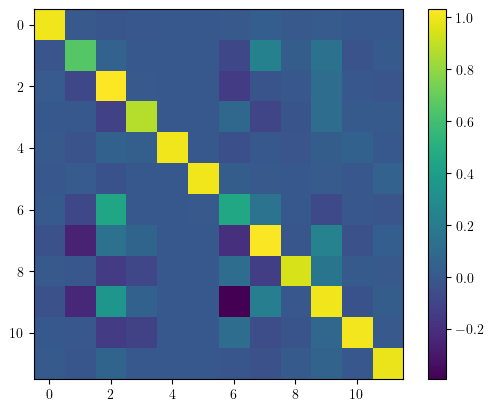

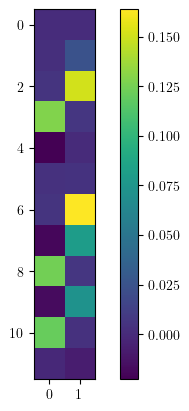

Error estimation norm
10.002438137360075
Print Eigvalues A
[0.47669576+0.j         0.85607086+0.j         0.90571306+0.07079039j
 0.90571306-0.07079039j 0.97766618+0.07581147j 0.97766618-0.07581147j
 0.92012562+0.j         0.96503771+0.j         1.0013819 +0.j
 0.99758679+0.0050216j  0.99758679-0.0050216j  0.99105334+0.j        ]


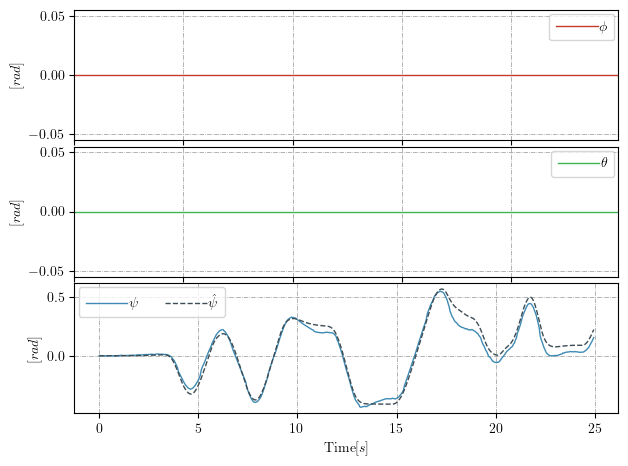

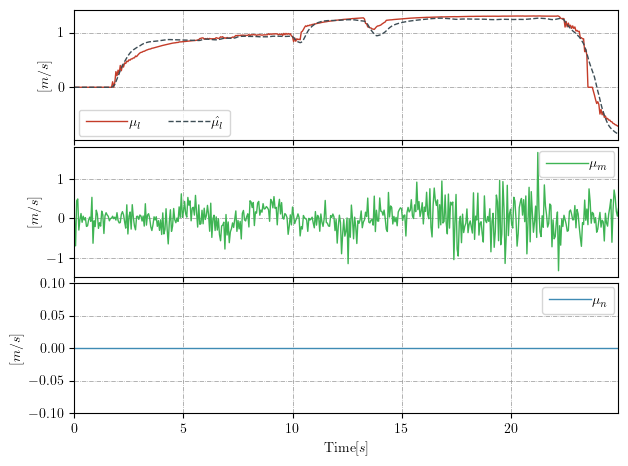

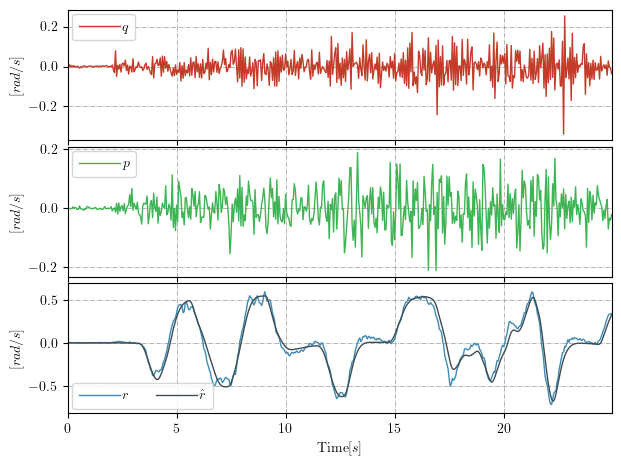

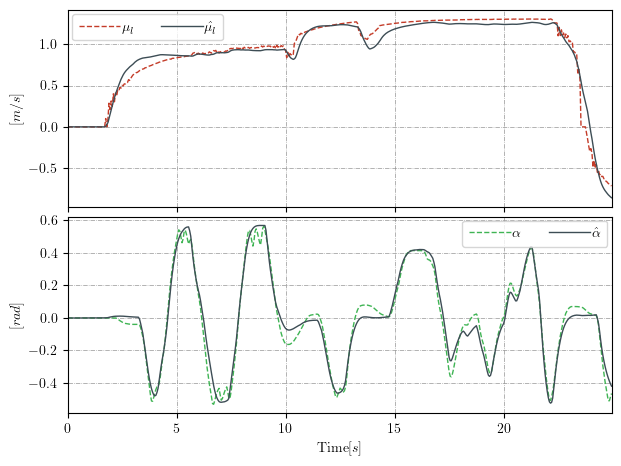

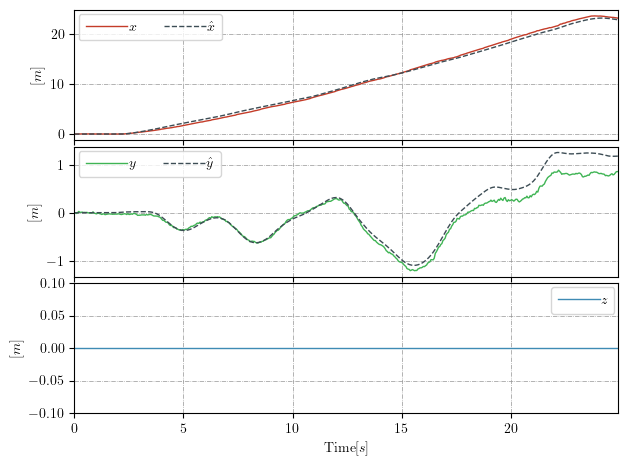

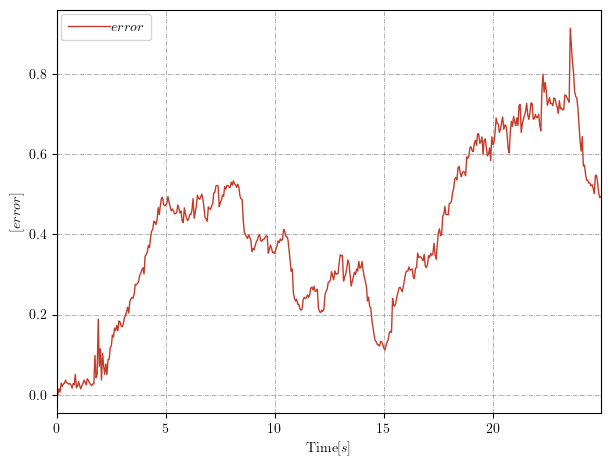

In [16]:
## Reshape Data
## Load Matrices from mat file
Data = scipy.io.loadmat('blue_data_02.mat')

## Get odometry of the system
data_odom_blue = Data['data_odom_blue']
data_odom_blue = data_odom_blue.T

## Get Control steer angle
steering_control = Data['steering_control']
steering_control = steering_control.T
steering_control = steering_control*(np.pi/180)

## Get Steer angle real
steering_real = Data['steering_real']
steering_real = steering_real.T
steering_real = steering_real*(np.pi/180)

## Get system velocities
vx = Data['vel_real']
vx = vx.T
vy = Data['vy']
vy = vy.T
vz = Data['vz']
vz = vz.T
wx = Data['wx']
wx = wx.T
wy = Data['wy']
wy = wy.T
wz = Data['wz']
wz = wz.T

## Get desired frontal velocity

vel_control = Data['vel_control']
vel_control = vel_control.T

h, hp, T = get_odometry(data_odom_blue, steering_real, vx, vy, vz, wx, wy, wz, vel_control, steering_control, 0, 500)
## Compute sample time of the system
ts = 0.05
t = np.zeros((T.shape[1]), dtype = np.double)
for k in range(0, T.shape[1]-1):
    t[k+1] = t[k] + ts


## Get Data DMD
X1_n, X2_n, U_n = get_simple_data(h, hp, T)
n_normal = X1_n.shape[0]

# Koopman Space
X1 = liftFun(X1_n)
X2 = liftFun(X2_n)
U = U_n

A_a = neural_network.A.cpu()
A_a = A_a.double()

A_a = A_a.detach().numpy()
B_a = neural_network.B.cpu()
B_a = B_a.double()

B_a = B_a.detach().numpy()

C_ones = np.eye(n_normal, dtype = np.double)
C_zeros = np.zeros((n_normal, n - n_normal), dtype=np.double)
C_a = np.hstack((C_ones, C_zeros))

## Plot matrix A
plt.imshow(A_a)
plt.colorbar()
plt.show()
#
# Plot matrix B
plt.imshow(B_a)
plt.colorbar()
plt.show()
#
# New variables in order to verify the identification
x_estimate = np.zeros((n_normal, X1.shape[1]+1), dtype=np.double)
output_estimate = np.zeros((n_normal, U.shape[1]), dtype=np.double)
output_real = np.zeros((n_normal, U.shape[1]), dtype=np.double)
error_vector = np.zeros((n_normal, U.shape[1]), dtype=np.double)
norm_error = np.zeros((1, U.shape[1]), dtype = np.double)

# Initial value
x_estimate[:, 0] = C_a@X1[:, 0]

for k in range(0, U.shape[1]):
    output_estimate[:, k] = x_estimate[:, k]
    output_real[:, k] = C_a@X1[:, k]

    error_vector[:, k] = output_real[:, k] - output_estimate[:, k]
    norm_error[:, k] = np.linalg.norm(error_vector[:, k])

    aux_states = liftFun_vector(x_estimate[:, k])
    x_estimate[:, k+1] = C_a@(A_a@aux_states + B_a@U[:, k])

print("Error estimation norm")
print(np.linalg.norm(norm_error))
eig_A, eigv_A = np.linalg.eig(A_a)
print("Print Eigvalues A")
print(eig_A)

fig13, ax13, ax23, ax33 = fancy_plots_3()
plot_states_angles_estimation(fig13, ax13, ax23, ax33, h[7:10, :], output_estimate[:, :], t, "Euler Angles Of the system")
plt.show()

fig15, ax15, ax25, ax35 = fancy_plots_3()
plot_states_velocity_lineal_estimation(fig15, ax15, ax25, ax35, hp[0:3, :], output_estimate[:, :], t, "Lineal Velocity of the system")
plt.show()

fig16, ax16, ax26, ax36 = fancy_plots_3()
plot_states_velocity_angular_estimation(fig16, ax16, ax26, ax36, hp[3:6, :], output_estimate[:, :], t, "Angular Velocity of the system")
plt.show()

fig17, ax17, ax27 = fancy_plots_2()
plot_control_states_estimation(fig17, ax17, ax27, h[:, :], hp[:, :], output_estimate[:, :], t, "Control and Real Values of the system")
plt.show()

fig14, ax14, ax24, ax34 = fancy_plots_3()
plot_states_position_estimation(fig14, ax14, ax24, ax34, h[0:3, :], output_estimate[:, :], t, "Position of the system")
plt.show()

fig18, ax18 = fancy_plots_1()
plot_error_estimation(fig18, ax18, norm_error, t, 'Error Norm of the Estimation')
plt.show()

In [17]:
losses["Koopman"]["collocation"]
costo = np.array(losses["Koopman"]["collocation"])
epochs = np.array(losses["Koopman"]["num_epochs"])
costo = costo.reshape(1, costo.shape[0])

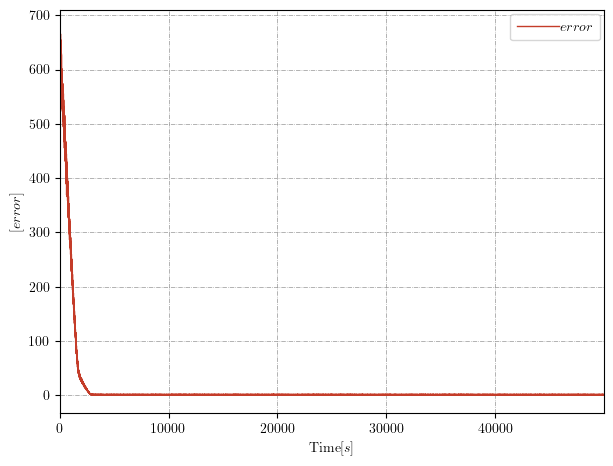

In [18]:
fig19, ax19 = fancy_plots_1()
plot_error_estimation(fig19, ax19, costo, epochs, 'Training Cost')
plt.show()

In [19]:
t.shape

(500,)

In [20]:
epochs

array([    0,     1,     2, ..., 49997, 49998, 49999])

In [21]:
costo

array([[634.71124268, 655.1519165 , 676.00769043, ...,   0.85033572,
          1.12877667,   1.30445576]])

In [22]:
np.tan(0)

0.0

In [23]:
np.cos(0)

1.0

In [24]:
np.tan(0)

0.0

In [25]:
np.sin(0)

0.0

In [26]:
0/20

0.0